# Study false detections around bright star masks
The radius of current HSC bright star masks, made by Andy Goulding, are selected by comparing the density of detections in increasingly large annuli around each bright stars with the average detection density. 

Still, false detections are present right outside the edge of masks for several objects. The aim of this notebook is to provide a plot of the number of detections as a function of increasing radius, around bright stars and beyond the edge of their mask, to visualize this problem.

## Options
You might want to change the two cells below.

The first one allows one to choose the path to the Butler repo we will read in, filter (note it only changes masks read in, since we read detections from merged catalog), tracts, and binning options for the annuli.

Normally, we'd select bright objects to study from an outside catalog (Gaia). But for now, we are just reading in the actual mask region files, which means we have to jump through a few extra hoops.
If we want to look at whole tracts, we can just set `reselectBrightObjects` to `False`; if further selection of bright objects is needed, pass on a string.
The only one recognized at the moment is `boxAround`, where we pick a rectangular box around the furthest detections (because I only reran on the inner 25 patches of a tract for analysis sprint). This is admittedly hacky, but it's temporary, while we work with Andy's masks (and might prove useful anyway, eg if we want to do this plot on the whole COSMOS field that is circular).

In [1]:
butlerPath = "/project/mschmitz/hscRerun/mynobg"

chosenFilter = "HSC-R" 
tractList = [9697] 
patchList = [["{},{}".format(i,j) for i in range(2,7) for j in range(2,7)]]

# Annuli parameters
annSize = 5 # radius of each consecutive annulus, in arcsec
nbAnnuli = 20 # number of annuli

# which detections to keep
reselectBrightObjects = "boxAround"#False

# print a few checkpoints, validation plots, etc
verbose = True

Change this cell if you want to save the end plot:

In [2]:
# whether to save plots and what to call them
savePlots = True
plotStub = "nobg_beyondMask"
plotExt = ".png"

The rest of the notebook should not require any changes before being ran (though note the cell that actually computes the number counts can take up to a few minutes per tract, depending on annuli parameters).

## Set up
Usual imports:

In [3]:
%matplotlib inline
import numpy as np
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst import geom
import matplotlib.pyplot as plt
import time
import os

Token to avoid rereading the detections every time, eg if we want to play with annuli parameters

In [4]:
src_loaded = False 

Initialize Butler repo:

In [5]:
butler = Butler(butlerPath)

If plots are to be saved, make sure the folder exists:

In [6]:
if savePlots:
    if not os.path.isdir('plots/'):
        os.makedirs('plots/')

Path to Andy Goulding's masks:

In [7]:
if chosenFilter=='HSC-G':
    filter_lc = 'g'
elif chosenFilter=='HSC-R':
    filter_lc = 'r'
elif chosenFilter=='HSC-I':
    filter_lc = 'i'
elif chosenFilter=='HSC-z':
    filter_lc = 'z'
elif chosenFilter=='HSC-y':
    filter_lc = 'y'
print(filter_lc)
mask_path = "/datasets/hsc/BrightObjectMasks/GouldingMasksS18A/new_S18Amask_{}.reg".format(filter_lc)

r


Extract mask information from the ds9 region files. Again, this is pretty hacky, but is only used for these specific masks - ultimately, it would be better to select the bright objects we look at from an external catalog (Gaia).

In [8]:
def extractBrightStarInfo(tractInfo, chosenFilter, mask_path, radMaxPix=0, verbose=False):
    f = open(mask_path, 'r')

    # boundaries; shrink BBox so largest annuli can fit in entirely
    bBox = tractInfo.getBBox()
    bBox.grow(-int(radMaxPix)-1)
    wcs = tractInfo.getWcs()

    pix_centers = []
    mags = []
    radii = []
    
    for line in f:
        if line[:6] == 'circle':
            maskinfo, comm = line.split('#')
            objid, mag = comm.split(',')
            maskinfo = maskinfo.split(',')
            radius = maskinfo[2].split('d')[0] # keep everything before the d
            circle = [float(maskinfo[0][7:]), # remove "circle("
                        float(maskinfo[1])]
            sp = geom.SpherePoint(circle[0], circle[1], geom.degrees)
            cpix = wcs.skyToPixel(sp)
            if (cpix[0] >= bBox.beginX and 
                cpix[0] < bBox.endX):
                if (cpix[1] >= bBox.beginY and 
                    cpix[1] < bBox.endY):
                    # also save magnitude (as put down by Andy)...
                    mag = float(mag[5:-2]) # remove " mag:" and the trailing \n
                    mags += [mag]
                    # ... and mask radius
                    radii += [float(radius)]
                    # if the center of the mask is inside, keep it
                    pix_centers += [cpix]
        elif line[:3] == 'box': # ignore saturation spikes/bleed trails boxes
            pass
        else: 
            if verbose:
                # check we didn't miss anything important
                print(line)
    f.close()
    mags = np.array(mags)
    radii = np.array(radii) * 3600 # arcsec
    return pix_centers, mags, radii

And function to compute (detected) source densities around a set of objects:

In [9]:
def sourceCountAround_meas(src, tractInfo, chosenFilter, nbAnnuli, annSizePix,
                           verbose=False, furtherBrightObjectSelector=None):
    """Compute detected source counts around all bright stars in the chosen tract.
    `src` should be a dataframe containing an `'x'` and a `'y'` column with pixel centroids
    for each detection.
    `tractInfo` the eponymous object for this tract from the sky map"""
    # extract bright star mask info for this tract
    brightCenters, brightMags, brightRadii = extractBrightStarInfo(tractInfo, chosenFilter, 
                                                                   mask_path, 
                                                                   verbose=verbose)
    # perform extra selection of bright objects among those masked if needed:
    if furtherBrightObjectSelector is not None:
        brightIdx = furtherBrightObjectSelector(brightCenters, brightMags, 
                                                brightRadii)
        brightCenters = [brightCenters[j] for j in brightIdx]
        brightMags = brightMags[brightIdx]
        brightRadii = brightRadii[brightIdx]
    
    allCounts = []
    allAreas = []
    for j,brightCen in enumerate(brightCenters):
        start = time.time()
        counts = []
        areas = []
        # compute annuli radii for this bright object
        brad = brightRadii[j]
        radiiPix = np.arange(brad, brad + annSizePix*(nbAnnuli + 1), annSizePix)
        radMaxPix = radiiPix[-1]
        # only consider detections within a square of width 2 outer radii
        withinSquare = ((src["base_SdssCentroid_x"] >= brightCen[0]-radMaxPix) &
                          (src["base_SdssCentroid_x"] < brightCen[0]+radMaxPix) &
                          (src["base_SdssCentroid_y"] >= brightCen[1]-radMaxPix) &
                          (src["base_SdssCentroid_y"] < brightCen[1]+radMaxPix)) 
        insideCents = np.array([obj.getCentroid() for obj in src[withinSquare]])
        # compute distance to bright object for all candidates
        dist = np.sqrt(np.sum((insideCents - brightCen)**2, axis=1))
        for radIn,radOut in zip(radiiPix,radiiPix[1:]):
            # count those within annulus
            inAnnulus = (dist >= radIn) & (dist < radOut)
            counts += [np.sum(inAnnulus)]
            areas += [np.pi *(radOut**2 - radIn**2)]
        
        end = time.time()
        if not j%500 and verbose:
            print(' > Bright object {} out of {}; time elapsed for this object: {}s'.format(
                j+1,len(brightCenters),end-start))
        allCounts += [counts]
        allAreas += [areas]
    allCounts = np.array(allCounts)
    allAreas = np.array(allAreas)
    return allCounts, allAreas, brightMags, brightRadii

Box selector to be used as a `furtherBrightObjectSelector` if we're not looking at whole tracts at a time:

In [13]:
def boxSelector(centers, radii, x0, y0, xWidth, yWidth, extraBuffer=0, 
                from_center=False):
    """ If `from_center`, check that centers fall within box; if `False`, that
    that a circle of radii `radii` do."""
    if from_center:
        buffers = np.zeros(radii.shape)
    else:
        buffers = radii + extraBuffer
    inside = np.array([(cent[0] - buffer > x0) & 
                       (cent[0] + buffer < x0 + xWidth) &
                       (cent[1] - buffer > y0) & 
                       (cent[1] + buffer < y0 + yWidth)
                   for cent,buffer in zip(centers, buffers)])
    return np.where(inside)[0]

## Run
Warning: running cell below can take a while.

In [14]:
densities, brightMags, brightRads = [], [], []
for tract,patches in zip(tractList,patchList):
    # get sky map and WCS for this tract
    skymap = butler.get("deepCoadd_skyMap", tract=tract, filter=chosenFilter)
    tractInfo = skymap[tract]
    wcs = tractInfo.getWcs()
    
    # convert annuli parameters to pixel
    pixScale = geom.radToArcsec(wcs.getPixelScale())
    annSizePix = annSize / pixScale
    
    # load detection catalog for each patch
    if verbose:
        print("Loading and appending all detections...")
    if not src_loaded:
        src = butler.get('deepCoadd_meas', tract=tract, patch=patches[0], 
                         filter=chosenFilter)
        src = src[src['detect_isPatchInner']]
        for patch in patches[1:]:
            patchSrc = butler.get('deepCoadd_meas', tract=tract, patch=patch, 
                                 filter=chosenFilter)
            patchSrc = patchSrc[patchSrc['detect_isPatchInner']]
            src.extend(patchSrc)
            src_loaded = True
    if verbose:
        print(" > Done.")
        
    # set up bright object selector if needed
    if reselectBrightObjects:
        if reselectBrightObjects == "boxAround":
            if verbose:
                print("Computing box boundaries...")
            # hacky box for a rectangular subset of patches within a tract:
            x0 = np.min(src["base_SdssCentroid_x"])
            xWidth = np.max(src["base_SdssCentroid_x"]) - x0 
            y0 = np.min(src["base_SdssCentroid_y"]) 
            yWidth = np.max(src["base_SdssCentroid_y"]) - x0 
            selector = lambda brightCenters, brightMags, brightRadii : boxSelector(
                        brightCenters, brightRadii, x0, y0, xWidth, yWidth,
                        extraBuffer = annSizePix*nbAnnuli)
            if verbose:
                print(" > Done.")
        else:
            raiseValueError("reselectBrightObjects {} not implemented".format(
                            reselectBrightObjects))
    else:
        selector = None
    
    if verbose:
        print("Computing number counts around bright objects...")
    counts, areas, mags, rads = sourceCountAround_meas(src, tractInfo, chosenFilter, 
                                                nbAnnuli, annSizePix, verbose=verbose,
                                                furtherBrightObjectSelector=selector)
    if verbose:
        print(" > Done.")
    # normalize by annulus area
    dens = counts / areas
    densities += [dens]
    brightMags += [mags]
    brightRads += [rads]

Loading and appending all detections...
 > Done.
Computing box boundaries...
 > Done.
Computing number counts around bright objects...
# BRIGHT STAR CATALOG: author:A.Goulding

# GENERATED ON: 2018-12-10

# TRACT: -1

# PATCH: -1,-1

# FILTER HSC-R

wcs; fk5

 > Bright object 1 out of 1074; time elapsed for this object: 0.31202125549316406s
 > Bright object 501 out of 1074; time elapsed for this object: 0.19925236701965332s
 > Bright object 1001 out of 1074; time elapsed for this object: 0.22573494911193848s
 > Done.


## Plot!

Compute distance to edge of each inner radius:

In [15]:
distanceToEdge = np.arange(0, annSize*nbAnnuli, annSize)

Plot a few individual objects first just to check:

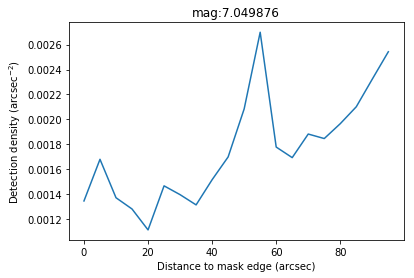

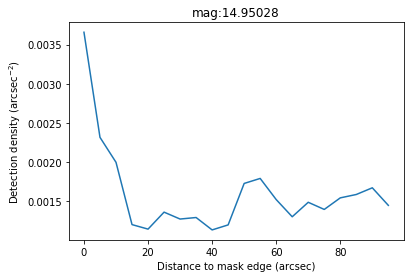

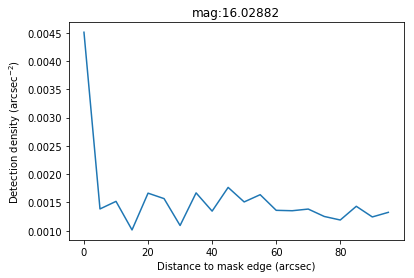

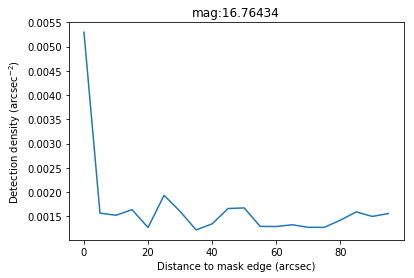

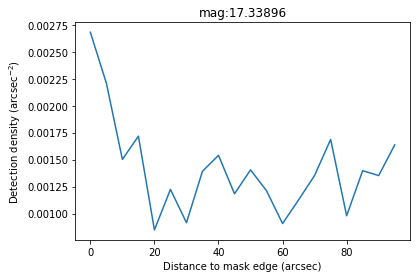

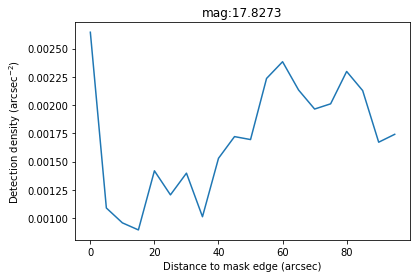

In [18]:
if verbose:
    for dens, mags, rads, in zip(densities, brightMags, brightRads):
        for starIdx in np.argsort(mags)[::199]:
            brst = dens[starIdx]
            plt.plot(distanceToEdge, brst)
            plt.xlabel('Distance to mask edge (arcsec)')
            plt.ylabel(r'Detection density (arcsec$^{-2}$)')
            plt.title('mag:{}'.format(mags[starIdx]))
            plt.show()
            plt.close()

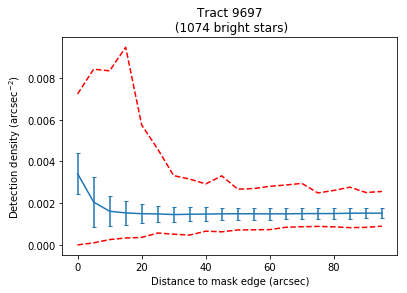

In [20]:
for tract, dens in zip(tractList, densities):
    # average detection densities around stars in this magnitude bin:
    magDen = np.mean(dens,axis=0)
    magDenStd = np.std(dens,axis=0)
    plt.errorbar(distanceToEdge, magDen, yerr=magDenStd, capsize=2)
    plt.plot(distanceToEdge, np.min(dens,axis=0), c='red', ls='--')
    plt.plot(distanceToEdge, np.max(dens,axis=0), c='red', ls='--')

    plt.title("Tract {}\n".format(tract)+" ({} bright stars)".format(len(dens)))

    plt.xlabel('Distance to mask edge (arcsec)')
    plt.ylabel(r'Detection density (arcsec$^{-2}$)')
    
    if savePlots:
        plt.savefig(plotStub + "tract{}".format(tract) + plotExt)
    plt.show()
    plt.close()